# Analysis of losses of an entertainment application.

Project Description

The customer company, the developer of the entertainment application, is suffering losses. 

Purpose of the study:

Find out the reasons for the losses incurred

Progress of the study:

Before we begin the analysis, it is necessary to evaluate what we have. Conduct information lustration so that unwanted elements do not spoil our picture. Comb it and bring it to a look that satisfies us. Then just take it and save everyone!


We have three datasets at our disposal. The file visits_info_short.csv stores the server log with information about site visits, orders_info_short.csv stores information about orders, and costs_info_short.csv stores information about advertising costs.

Structure of visits_info_short.csv:

User Id - unique user identifier,

Region — user country,

Device — user device type,

Channel — transition source identifier,

Session Start - date and time of the start of the session,

Session End - date and time of the end of the session.

Structure of orders_info_short.csv:

User Id - unique user identifier,

Event Dt - date and time of purchase,

Revenue — order amount.

Structure of costs_info_short.csv:

dt — date of the advertising campaign,

Channel — advertising source identifier,

costs — costs for this campaign.

## 1. Data overview / Data preprocessing.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
visits = pd.read_csv('visits_info_short.csv')

In [3]:
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])

In [4]:
visits.columns= visits.columns.str.lower()

In [5]:
visits.rename(columns={'user id':'user_id', 'session start':'session_start', 'session end':'session_end'}, inplace = True)

In [6]:
print(visits.isna().sum());
print(visits.duplicated().sum());
print((visits).head(5));

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64
0
        user_id         region   device  channel       session_start  \
0  981449118918  United States   iPhone  organic 2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic 2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic 2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop 2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic 2019-05-01 03:33:35   

          session_end  
0 2019-05-01 02:45:01  
1 2019-05-01 04:47:35  
2 2019-05-01 15:32:08  
3 2019-05-01 00:54:25  
4 2019-05-01 03:57:40  


In [7]:
orders = pd.read_csv('orders_info_short.csv')

In [8]:
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])

In [9]:
orders.columns= orders.columns.str.lower()

In [10]:
orders.rename(columns={'user id':'user_id', 'event dt':'event_dt'}, inplace = True)

In [11]:
print(orders.isna().sum())
print(orders.duplicated().sum())
print(orders.head(5))

user_id     0
event_dt    0
revenue     0
dtype: int64
0
        user_id            event_dt  revenue
0  188246423999 2019-05-01 23:09:52     4.99
1  174361394180 2019-05-01 12:24:04     4.99
2  529610067795 2019-05-01 11:34:04     4.99
3  319939546352 2019-05-01 15:34:40     4.99
4  366000285810 2019-05-01 13:59:51     4.99


In [12]:
costs = pd.read_csv('costs_info_short.csv')

In [13]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [14]:
costs.columns= costs.columns.str.lower()

In [15]:
print(costs.isna().sum())
print(costs.duplicated().sum())
print(costs.head(5))

dt         0
channel    0
costs      0
dtype: int64
0
           dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1


## 2. Let's set functions for calculating and analyzing LTV, ROI, retention and conversion.

Functions for calculating metric values:

- `get_profiles()` - to create user profiles,
- `get_retention()` - for calculating Retention Rate,
- `get_conversion()` - for calculating conversion,
- `get_ltv()` - for calculating LTV.

Functions for plotting:

- `filter_data()` - for data smoothing,
- `plot_retention()` - to plot the Retention Rate graph,
- `plot_conversion()` — for plotting a conversion graph,
- `plot_ltv_roi()` - for visualizing LTV and ROI.

In [16]:
# function for creating user profiles

def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # find the parameters of the first visits
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # for cohort analysis, we determine the date of the first visit and the first day of the month in which this visit occurred

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # add a sign of paying users
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # add flags for all events from event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # We count the number of unique users with the same source and date of attraction
    
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # we combine spending on advertising and the number of attracted users
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # divide advertising costs by the number of attracted users
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # add acquisition cost to profiles
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # the cost of attracting organic users is zero
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [17]:
# function for calculating retention

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # add the 'payer' column to the passed dimensions list
    dimensions = ['payer'] + dimensions

    # we exclude users who have not “lived up” to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # collecting “raw” data to calculate retention
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # function for grouping tables according to desired characteristics
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # we get the retention table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # we get a table of retention dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # return both tables and raw data
    return result_raw, result_grouped, result_in_time

In [18]:
# function for calculating conversion

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # we exclude users who have not “lived up” to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # We determine the date and time of the first purchase for each user
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # adding purchase data to profiles
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # We calculate life time for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # function for grouping tables according to desired characteristics
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        # divide each “cell” in the row by the size of the cohort and get the conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # we get the conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # for the conversion dynamics table, remove 'cohort' from dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # we get a table of conversion dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # return both tables and raw data
    return result_raw, result_grouped, result_in_time

In [19]:
# function for calculating LTV and ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # we exclude users who have not “lived up” to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # adding purchase data to profiles
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # We calculate the user’s life time for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    # group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # grouping function according to desired characteristics
    def group_by_dimensions(df, dims, horizon_days):
        # building a “triangular” revenue table
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # find the amount of revenue with accumulation
        result = result.fillna(0).cumsum(axis=1)
        # calculate cohort sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # combining cohort sizes and revenue table
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # We calculate LTV: we divide each “cell” in the row by the size of the cohort
        result = result.div(result['cohort_size'], axis=0)
        # we exclude all life times exceeding the analysis horizon
        result = result[['cohort_size'] + list(range(horizon_days))]
        # restoring cohort sizes
        result['cohort_size'] = cohort_sizes

        # We collect a dataframe with user data and CAC values, adding parameters from dimensions
      
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # We calculate the average CAC according to parameters from dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # We calculate ROI: divide LTV by CAC
        roi = result.div(cac['cac'], axis=0)

        # remove lines with infinite ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # restoring cohort sizes in the ROI table
        roi['cohort_size'] = cohort_sizes

        # adding CAC to the ROI table
        roi['cac'] = cac['cac']

        # in the final table we leave cohort sizes, CAC and ROI in life times not exceeding the analysis horizon
      
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # return LTV and ROI tables
        return result, roi

    # we get LTV and ROI tables
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # for dynamics tables, remove 'cohort' from dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # we get tables of LTV and ROI dynamics
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # raw data
        result_grouped,  # LTV table
        result_in_time,  # LTV dynamics table
        roi_grouped,  # ROI table
        roi_in_time,  # ROI dynamics table
    )

In [20]:
# function for frame 'smoothing'

def filter_data(df, window):
    # For each column we apply a moving average
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [21]:
# function to visualize retention

def plot_retention(retention, retention_history, horizon, window=7):

    # set the grid size for graphs
    plt.figure(figsize=(15, 10))

    # exclude cohort sizes and first day retention
    retention = retention.drop(columns=['cohort_size', 0])
    # in the dynamics table we leave only the required lifetime
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # if there is only payer in the indexes of the retention table, add a second sign - cohort

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # in the graph table - two columns and two rows, four cells. In the first we build retention curves for paying users
  
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of paying users')
 
    # in the second cell we construct retention curves for non-payers. The vertical axis is from the graph from the first cell
  
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of non-paying users')

    # in the third cell - the dynamics of retention of paying
    ax3 = plt.subplot(2, 2, 3)
    # get column names for pivot tablesы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # filter the data and build a graph
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Date of attraction')
    plt.title(
        'Dynamics of retention of paying users on the {}th day'.format(
            horizon
        )
    )

    # in the fourth cell - the dynamics of retention of non-payers
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # filter the data and build a graph
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Date of attraction')
    plt.title(
        'Dynamics of retention of non-paying users on the {}th day'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [22]:
# function for visualizing conversion

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # set the grid size for graphs
    plt.figure(figsize=(15, 5))

    # exclude cohort sizes
    conversion = conversion.drop(columns=['cohort_size'])
    # in the dynamics table we leave only the required lifetime
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # first graph - conversion curves
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('User Conversion')

    # second graph - conversion dynamics
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # all index columns except date will become pivot table columns
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Date of attraction')
    plt.title('Dynamics of user conversion on the {}th day'.format(horizon))

    plt.tight_layout()
    plt.show()

In [23]:
# function for visualizing LTV and ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # set the grid for drawing graphs
    plt.figure(figsize=(20, 10))

    # we exclude cohort sizes from the ltv table
    ltv = ltv.drop(columns=['cohort_size'])
    # in the ltv dynamics table we leave only the required lifetime
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # the cost of attraction will be recorded in a separate frame
    cac_history = roi_history[['cac']]

    # from the roi table we exclude cohort sizes and cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # in the roi dynamics table we leave only the required lifetime
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # first graph - ltv curves
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    # second graph - ltv dynamics
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # all index columns except date will become pivot table columns
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Date of attraction')
    plt.title('Dynamics of LTV of users on the {}th day'.format(horizon))

    # third graph—cac dynamics
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # all index columns except date will become pivot table columns
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Date of attraction')
    plt.title('Dynamics of user acquisition cost')

    # fourth graph - roi curves
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    # fifth graph - roi dynamics
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # all index columns except date will become pivot table columns
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.xlabel('Date of attraction')
    plt.title('Dynamics of user ROI on the {}th day'.format(horizon))

    plt.tight_layout()
    plt.show()

## 3. Data analysis.

In [24]:
# Let's create user profiles. 
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5)) 

# We will determine the minimum and maximum dates for attracting users.
print(profiles['first_ts'].min())
print(profiles['first_ts'].max())

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  
2019-05-01 00:00:41
2019-10-27 23:59:04


Using the get_profiles function, we have compiled an array through which we can conduct analysis. Combined data. We identified the sign of paying users, the cost of attraction, etc. Now we can dig!

In [25]:
# Let's find out from which countries users come to the application and which country accounts for the most paying users.
# Let's build a table reflecting the number of users and the share of paying people from each country.

country = profiles.groupby('region').count().sort_values(by='payer', ascending = False)
country = country.drop(['user_id', 'first_ts', 'channel', 'device', 'dt', 'month', 'acquisition_cost'], axis =1)

payed_country = profiles[(profiles['payer'] == True)].groupby('region').count().sort_values(by='payer', ascending = False)
payed_country = payed_country.drop(['user_id', 'first_ts', 'channel', 'device', 'dt', 'month', 'acquisition_cost'], axis =1)

payed_country_result = pd.merge(country, payed_country, on = ['region'])
payed_country_result = payed_country_result.rename(columns={ 'payer_x': 'users', 'payer_y': 'payers'})
payed_country_result['payers_%'] = (payed_country_result['payers'] / payed_country_result['users']) * 100

print(payed_country_result)

                users  payers  payers_%
region                                 
United States  100002    6902  6.901862
UK              17575     700  3.982930
France          17450     663  3.799427
Germany         14981     616  4.111875


Users of the application are citizens of 4 countries: America, Great Britain, France and Germany.
The shares of paying users to the total number of users by country were distributed as follows:
America 6.9%
Great Britain 3.98%
France 3.79%
Germany 4.11%

In [26]:
# Find out what devices customers use and what devices are preferred by paying users.
# Let's build a table reflecting the number of users and the share of paying for each device.

devices = profiles.groupby('device').count().sort_values(by='payer', ascending = False)
devices = devices.drop(['user_id', 'first_ts', 'channel', 'region', 'dt', 'month', 'acquisition_cost'], axis =1)
devices = devices.rename(columns={ 'payer': 'users'})

payed_devices = profiles[(profiles['payer'] == True)].groupby('device').count().sort_values(by='payer', ascending = False)
payed_devices = payed_devices.drop(['user_id', 'first_ts', 'channel', 'region', 'dt', 'month', 'acquisition_cost'], axis =1)

payed_devices_result = pd.merge(devices, payed_devices, on = ['device'])
payed_devices_result['payers_%'] = (payed_devices_result['payer'] / payed_devices_result['users']) * 100

print(payed_devices_result.sort_values(by = 'payers_%',ascending = False))

         users  payer  payers_%
device                         
Mac      30042   1912  6.364423
iPhone   54479   3382  6.207897
Android  35032   2050  5.851793
PC       30455   1537  5.046790


Users prefer 4 types of devices: iPhone, Android, Mac and PC. The shares of paying users by device are as follows:

Mac 6.36% 
iPhone 6.20% 
Android 5.85% 
PC 5.04%

In [27]:
# Let's study advertising sources of attraction and determine the channels from which the most paying users came.
# Let's build a table reflecting the number of users and the share of paying people for each acquisition channel.

channels = profiles.groupby('channel').count().sort_values(by='payer', ascending = False)
channels = channels.drop(['user_id', 'first_ts', 'device', 'region', 'dt', 'month', 'acquisition_cost'], axis =1)
channels = channels.rename(columns={ 'payer': 'users'})

payed_channels = profiles[(profiles['payer'] == True)].groupby('channel').count().sort_values(by='payer', ascending = False)
payed_channels = payed_channels.drop(['user_id', 'first_ts', 'device', 'region', 'dt', 'month', 'acquisition_cost'], axis =1)

payed_channels_result = pd.merge(channels, payed_channels, on = ['channel'])
payed_channels_result['payers_%'] = (payed_channels_result['payer'] / payed_channels_result['users']) * 100

print(payed_channels_result.sort_values(by = 'payers_%',ascending = False))

                    users  payer   payers_%
channel                                    
FaceBoom            29144   3557  12.204914
AdNonSense           3880    440  11.340206
lambdaMediaAds       2149    225  10.469986
TipTop              19561   1878   9.600736
RocketSuperAds       4448    352   7.913669
WahooNetBanner       8553    453   5.296387
YRabbit              4312    165   3.826531
MediaTornado         4364    156   3.574702
LeapBob              8553    262   3.063253
OppleCreativeMedia   8605    233   2.707728
organic             56439   1160   2.055316


Conclusion:

There are channels, but, as they say, not all yoghurts are equally healthy. Top 3 in % looks like this:

FaceBoom 12.20%
AdNonSense 11.34%
lambdaMediaAds 10.46%

## 4. Marketing.

In [28]:
# Let's calculate the total amount of marketing expenses.

print(round(profiles['acquisition_cost'].sum(), 2))

105497.3


In [29]:
# Let's find out how spending is distributed among advertising sources, that is, how much money was spent on each source.

print(profiles['acquisition_cost'].groupby(profiles['channel']).sum().sort_values(ascending = False));

channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
organic                   0.00
Name: acquisition_cost, dtype: float64


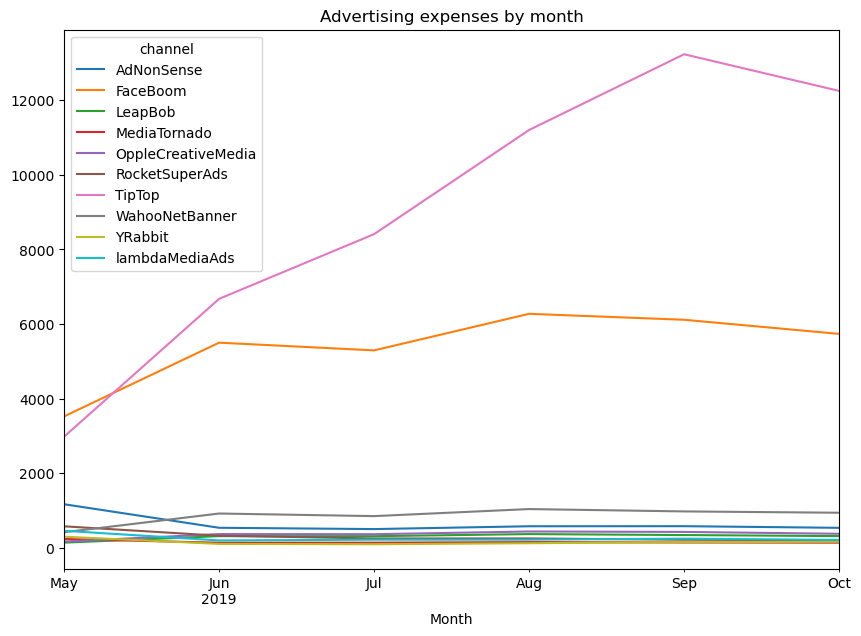

In [30]:
# Let's build a visualization of the dynamics of changes in expenses over time (by weeks and months) for each source.

costs['Expenses by month'] = costs['dt'].astype('datetime64[M]')
costs.pivot_table(index = 'Expenses by month', columns = 'channel', values = 'costs', aggfunc = 'sum').plot(figsize = (10, 7))
plt.xlabel('Month')
plt.title('Advertising expenses by month');

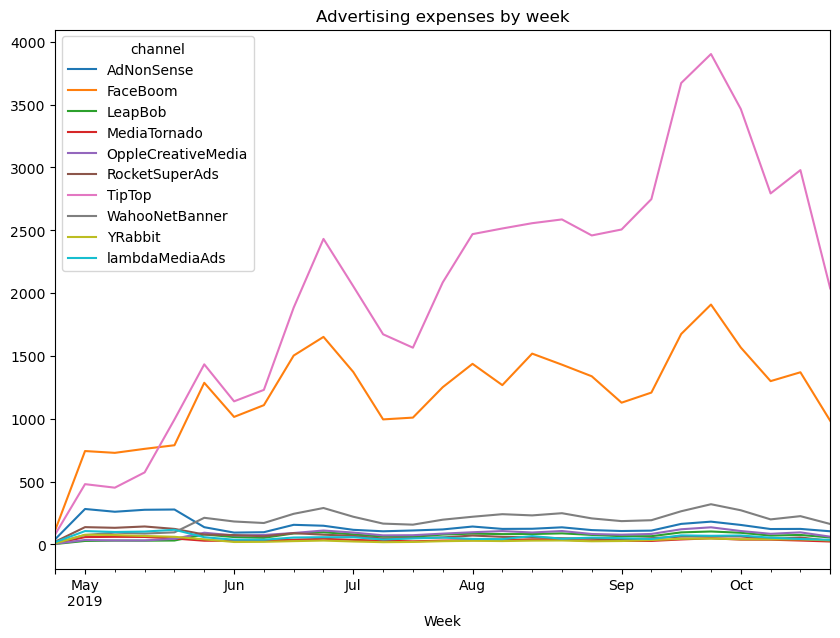

In [31]:
costs['Expenses by week'] = costs['dt'].astype('datetime64[W]')
costs.pivot_table(index = 'Expenses by week', columns = 'channel', values = 'costs', aggfunc = 'sum').plot(figsize = (10, 7))
plt.xlabel('Week')
plt.title('Advertising expenses by week');

Spending on FB and TT channels is breaking records, but this fact itself doesn’t tell us anything special yet. We need to look at the payback.

In [32]:
# Let's find out how much it cost on average to attract one user (CAC) from each source.

print(profiles.groupby('channel').agg({'user_id': 'nunique', 'acquisition_cost': 'mean'})\
      .sort_values(by='acquisition_cost', ascending=False))

                    user_id  acquisition_cost
channel                                      
TipTop                19561          2.799003
FaceBoom              29144          1.113286
AdNonSense             3880          1.008054
lambdaMediaAds         2149          0.724802
WahooNetBanner         8553          0.602245
RocketSuperAds         4448          0.412095
OppleCreativeMedia     8605          0.250000
YRabbit                4312          0.218975
MediaTornado           4364          0.218717
LeapBob                8553          0.210172
organic               56439          0.000000


In [33]:
profiles['acquisition_cost'].mean()

0.7032778251827625

An analysis of marketing costs showed that the cost of attracting customers in the TipTop and FaceBoom channels has increased incredibly and is many times higher than in other sources.

## 5. Let's evaluate the return on advertising.

In [34]:
# Let's analyze the payback of advertising using LTV and ROI graphs, as well as graphs of LTV, CAC and ROI dynamics.

observation_date = datetime(2019, 11, 1).date()  
horizon_days = 14 

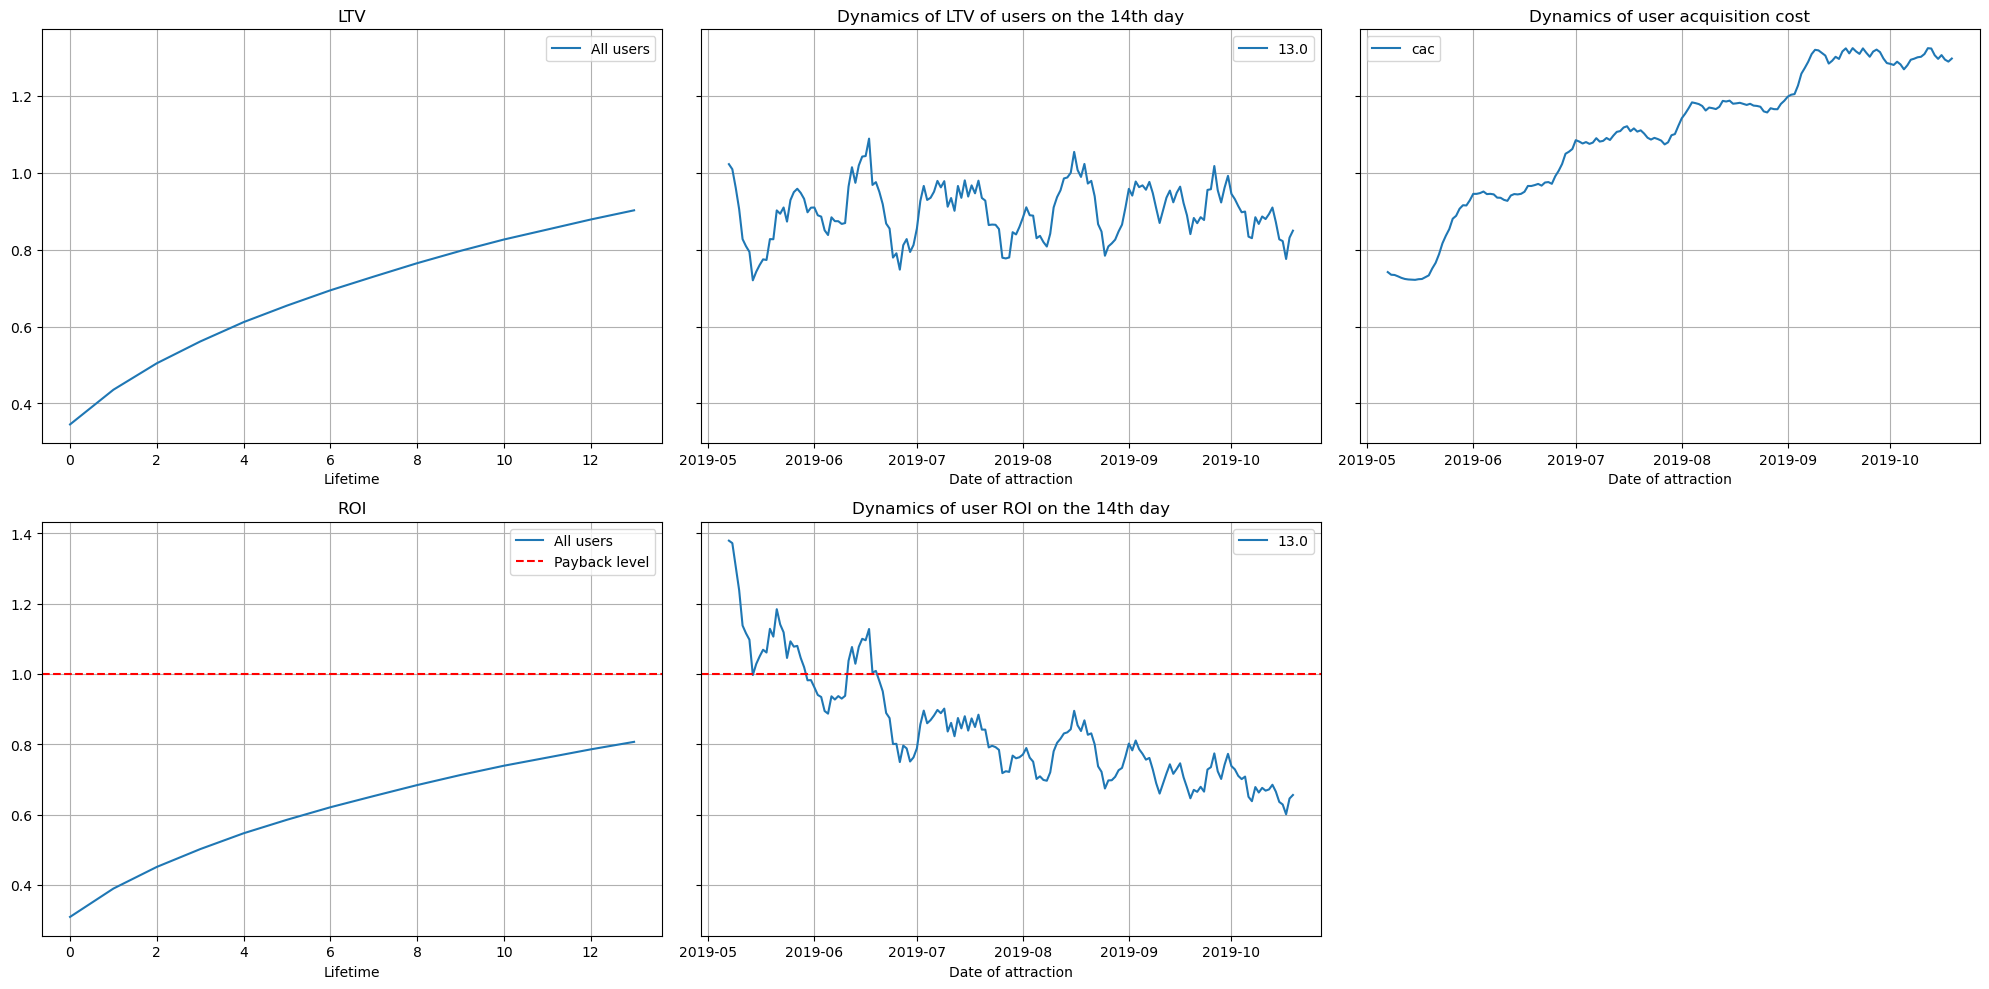

In [35]:
profiles = profiles.query('channel != "organic"')

# Let's count LTV и ROI:

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

# Let's build graphs:

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

The graph is built correctly. The LTV and ROI charts are growing, but not dynamically. Here everything is just the opposite, while the cost of attraction rushed up like a rocket.

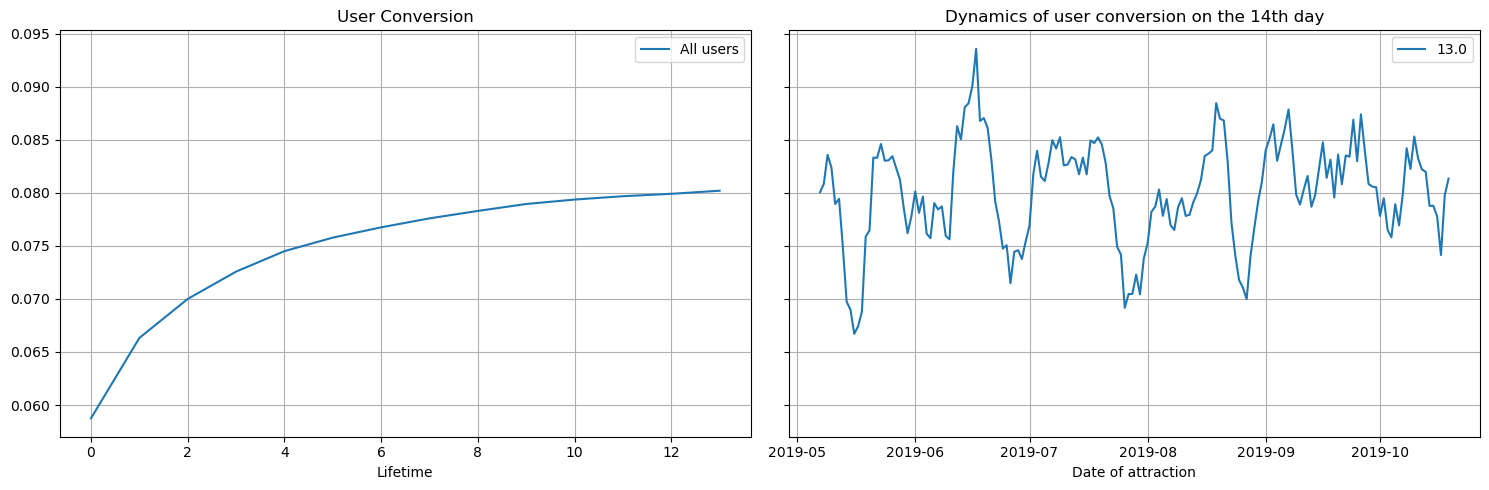

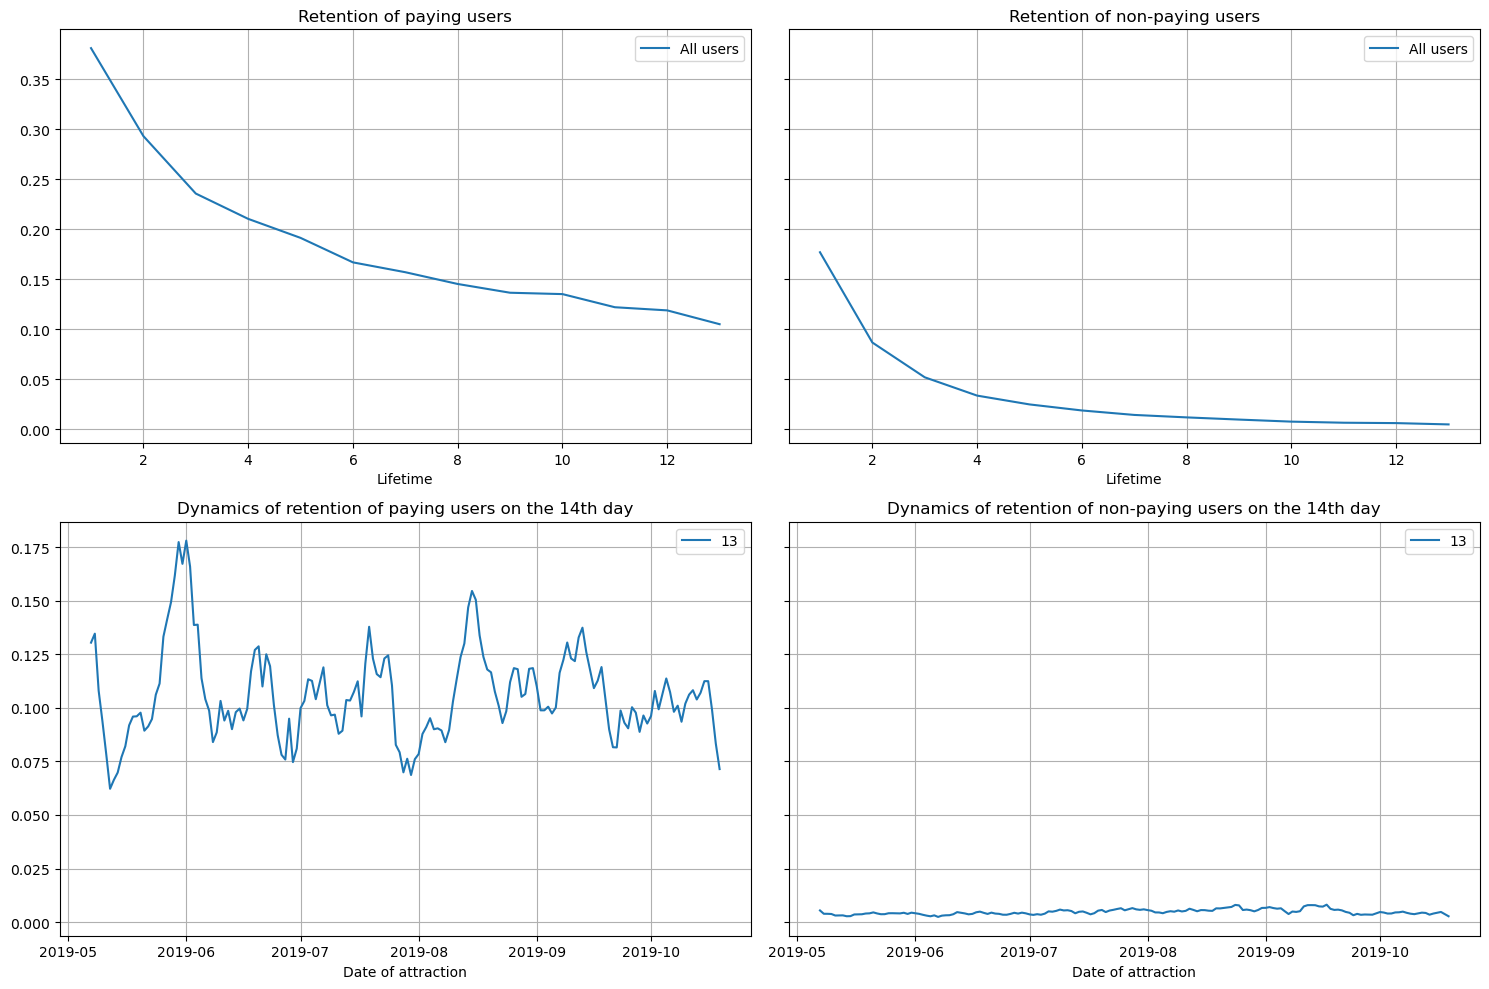

In [36]:
# We will build and study conversion and retention charts.

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days)



# Let's build graphs:

plot_conversion(conversion_grouped, conversion_history, horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days)

Conversion and retention rates look quite healthy. Everything is according to the textbook. Conversion is growing. Retaining those who pay is better than those who do not... Beauty!

In [37]:
# We will build graphs of LTV and ROI by device, as well as graphs of the dynamics of LTV, CAC and ROI.

dimensions = ['device']

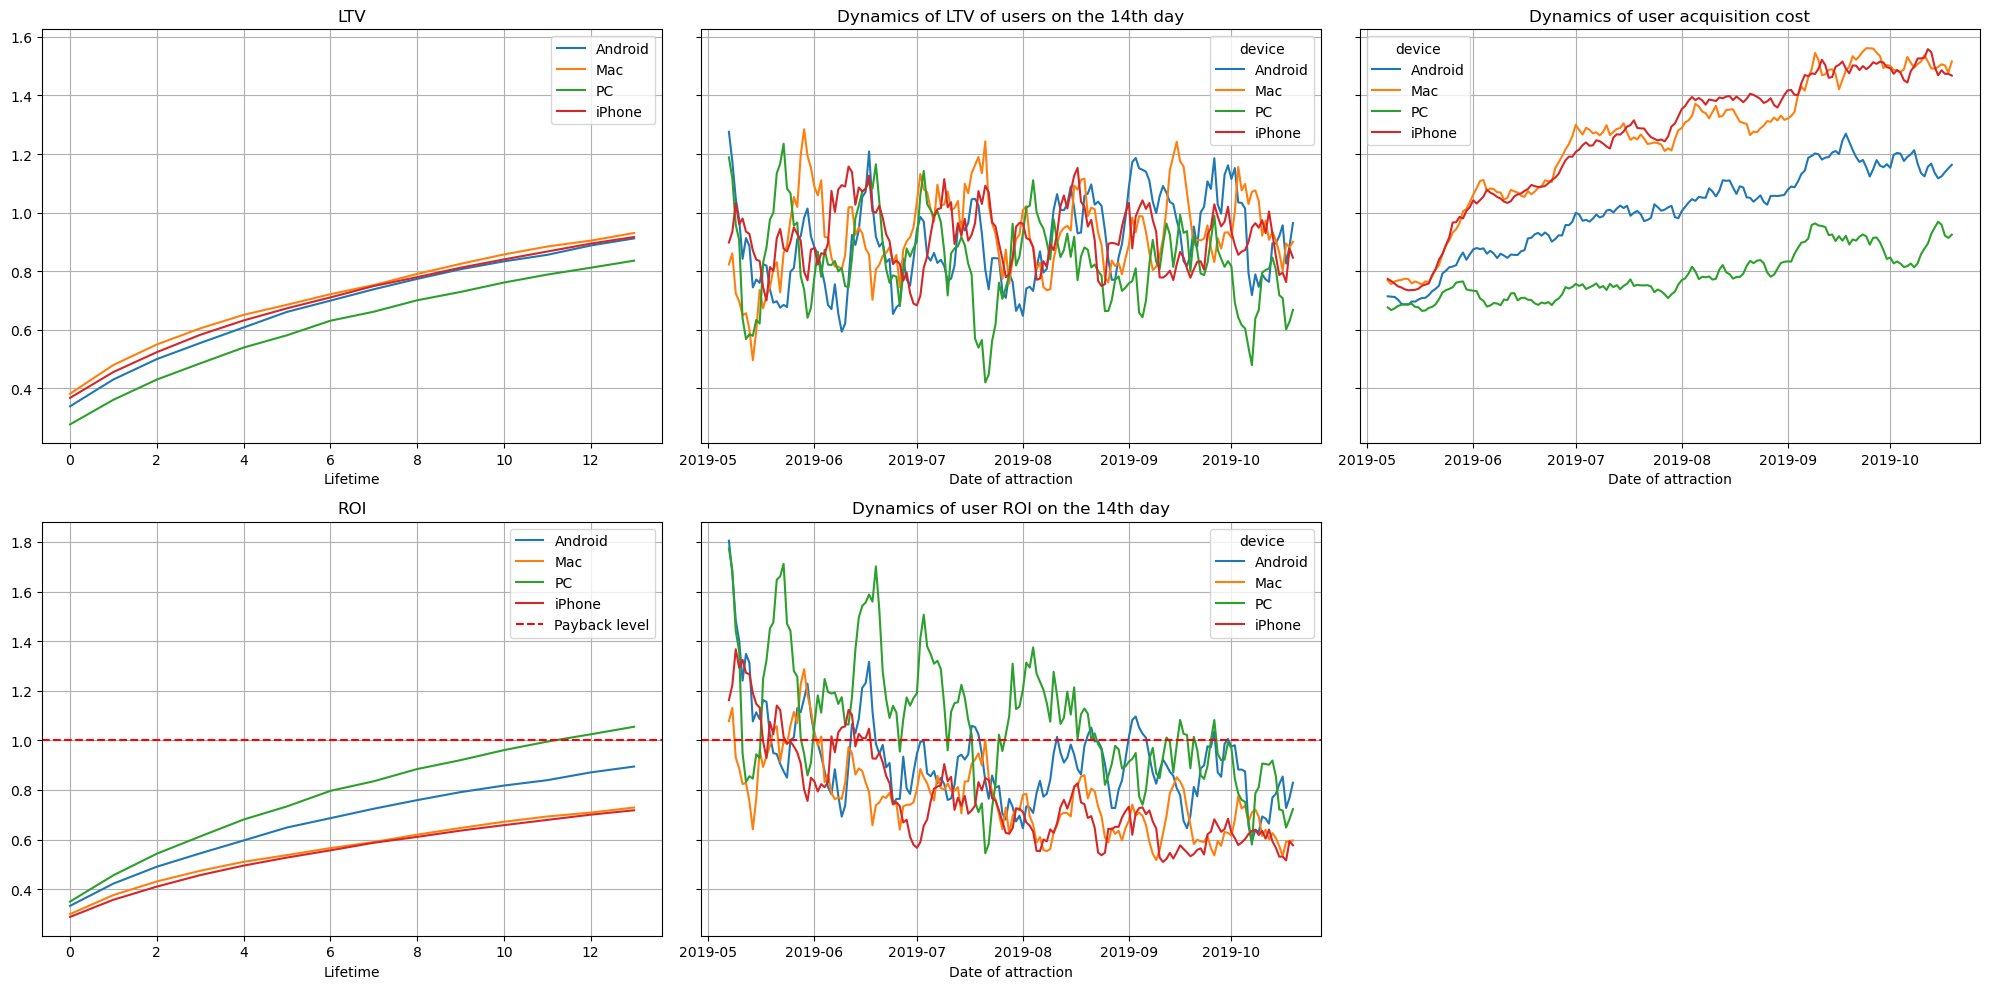

In [38]:
# We calculate LTV and ROI by device:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions)

# Let's build graphs:

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

In terms of devices, the following picture is observed:
1. PC do not pay off at all.
2. Cost of acquisition is rising across all devices.

In [39]:
# We will build graphs of LTV and ROI by country, as well as graphs of the dynamics of LTV, CAC and ROI.

dimensions = ['region']

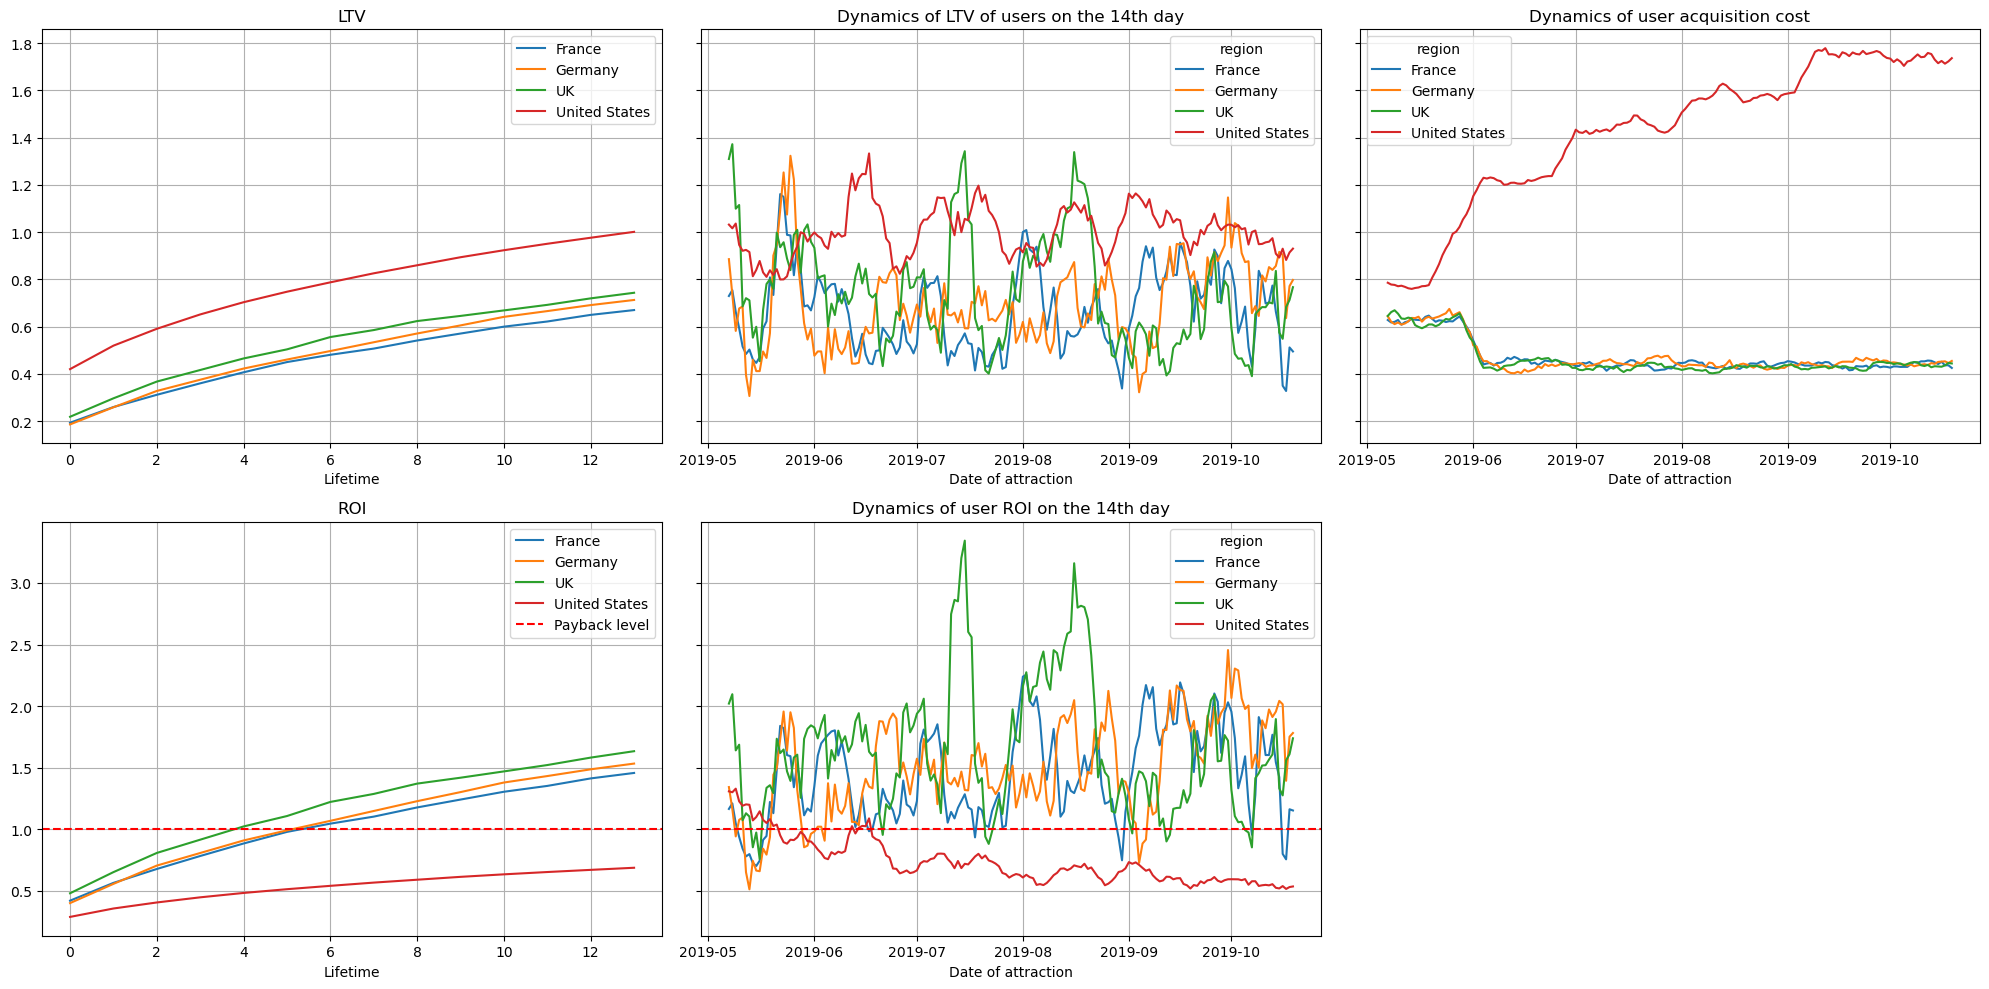

In [40]:
# We calculate LTV and ROI by country:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions)

# Let's build graphs:

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

SAS in the USA simply flew into the skies. America set us up and is not paying off.

In [41]:
# We will build graphs of LTV and ROI by advertising channels, as well as graphs of the dynamics of LTV, CAC and ROI.

dimensions = ['channel']

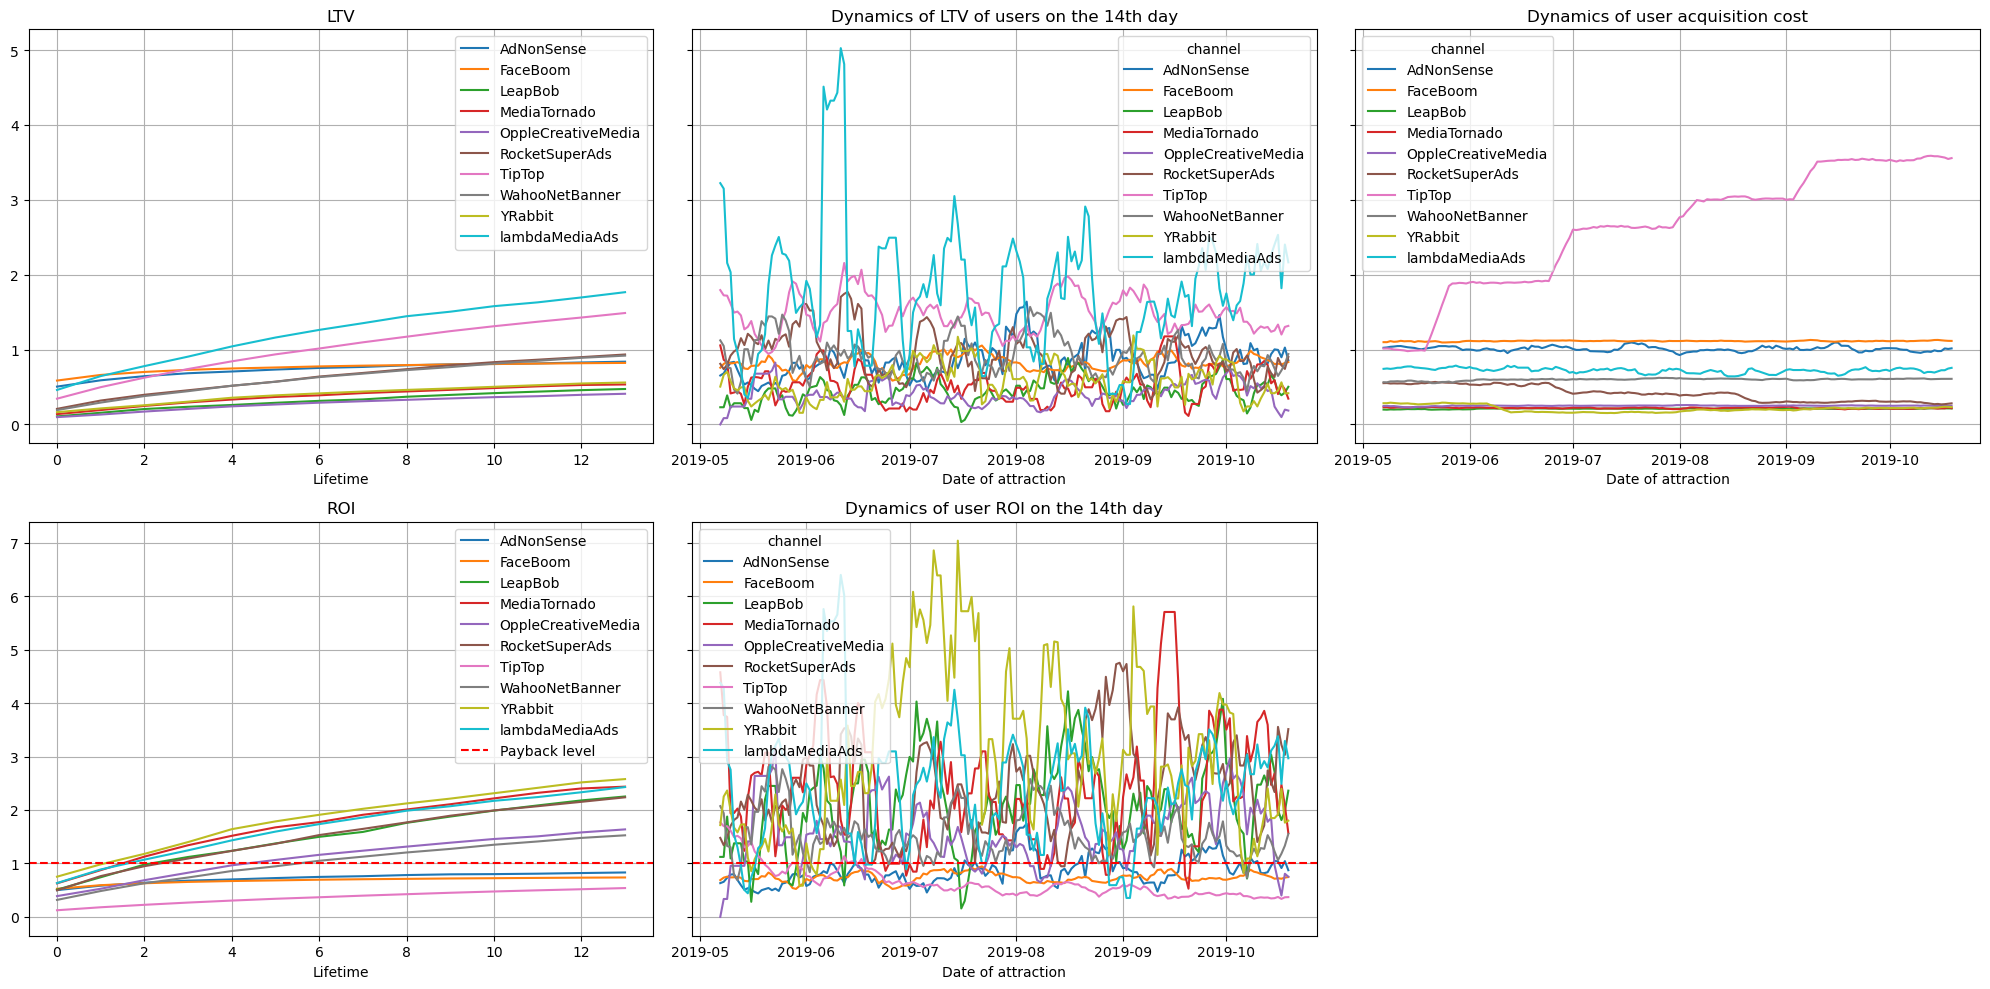

In [42]:
# We calculate LTV and ROI in terms of acquisition channels:

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions)

# Let's build graphs:

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Advertising in general does not pay off.
The US region, personal computers, and advertising channels AdNonSense, FaceBoom and TipTop have a negative impact.
CAC in TipTop is generally growing indecently, let’s leave the comparisons, only indecent ones remain.

Let's dive deeper

In [43]:
# Let's build graphs of LTV CAC and ROI by country by advertising channel:

# Let's cut across the USA:
current_profiles = profiles.query('region == "United States"')

# Adding channels:
dimensions = ['channel']

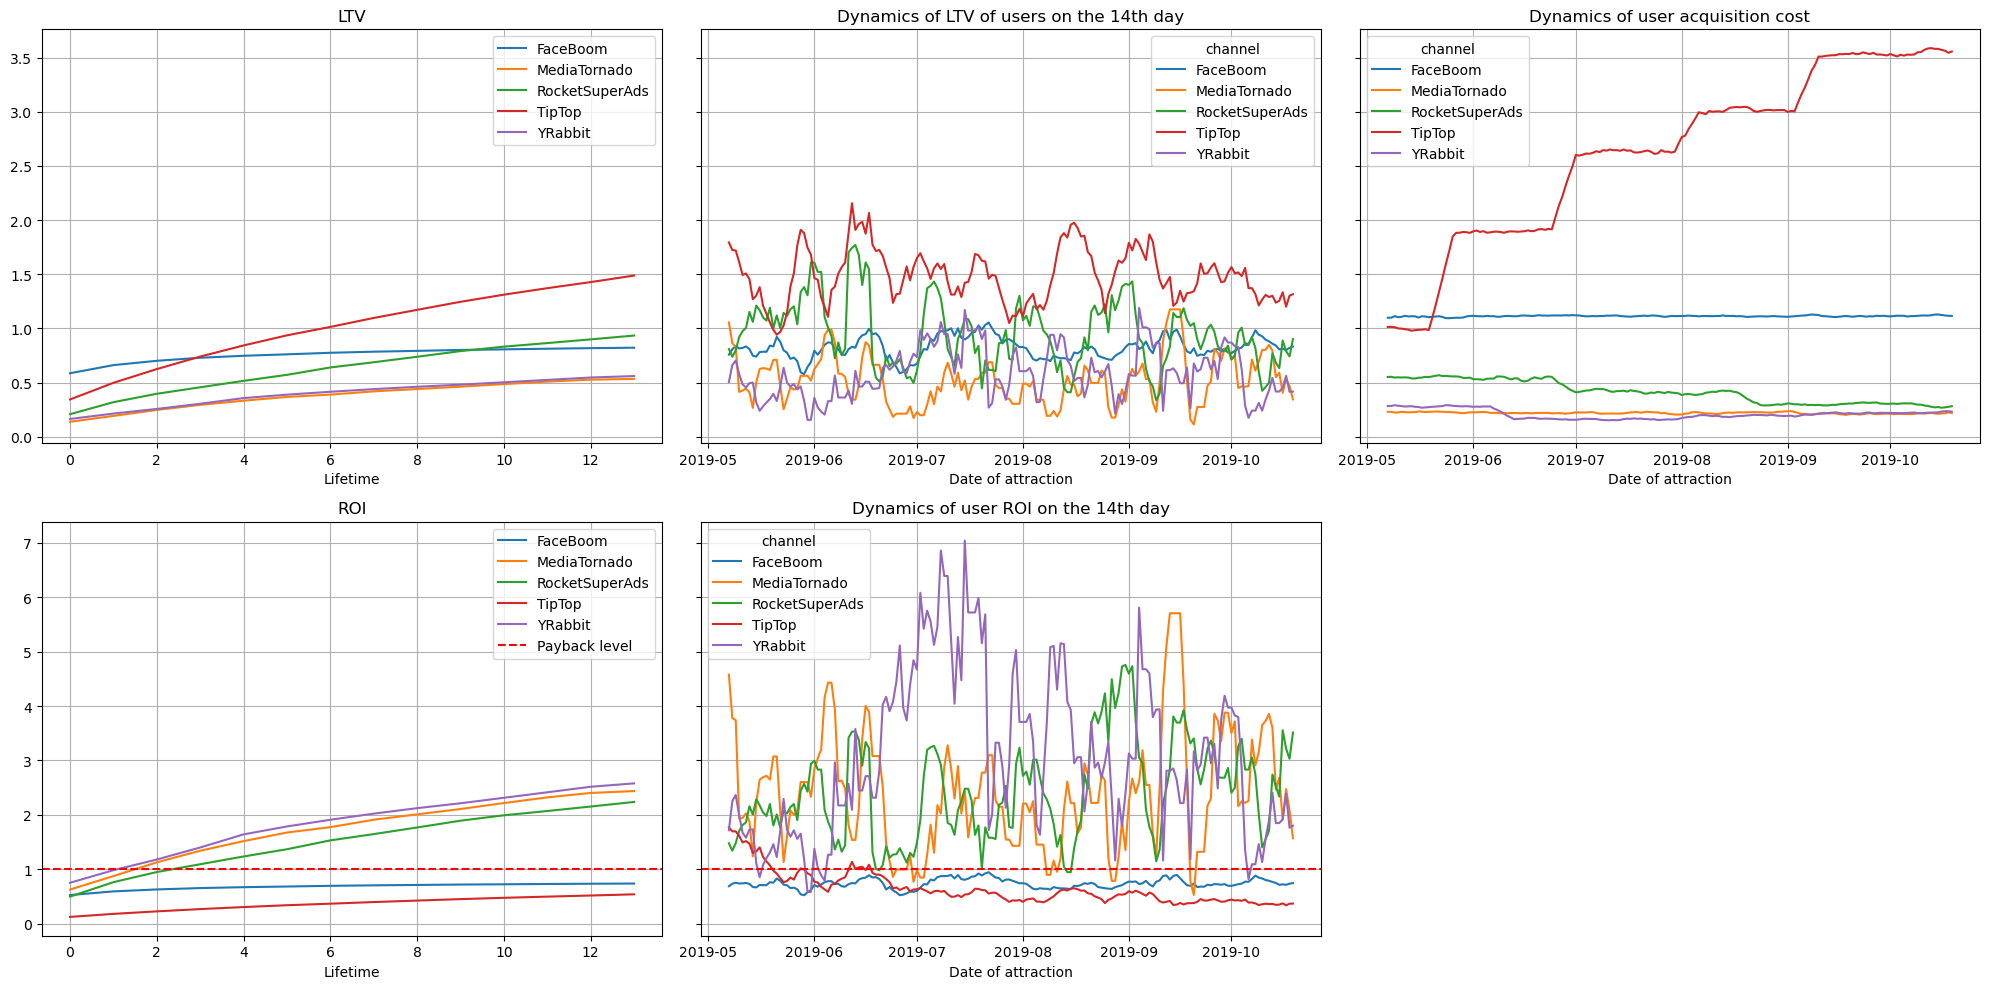

In [44]:
# We calculate LTV and ROI by advertising channel:

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
        current_profiles, orders, observation_date, horizon_days, dimensions = dimensions)

# Let's build graphs:

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

In the US, FaceBoom and TipTop are hitting rock bottom.

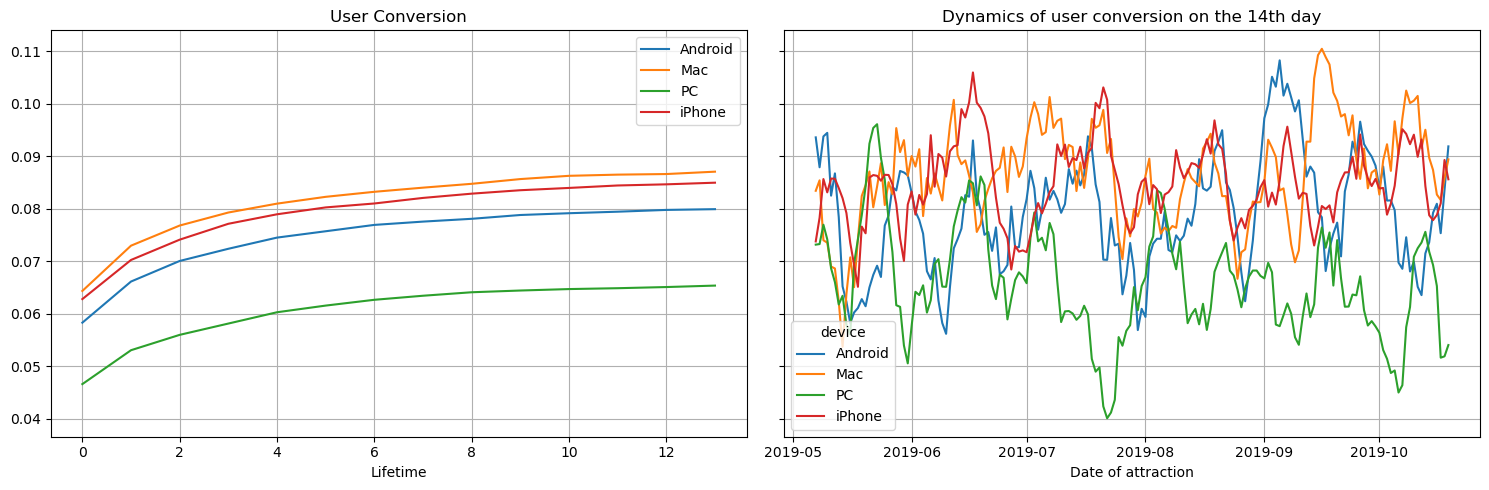

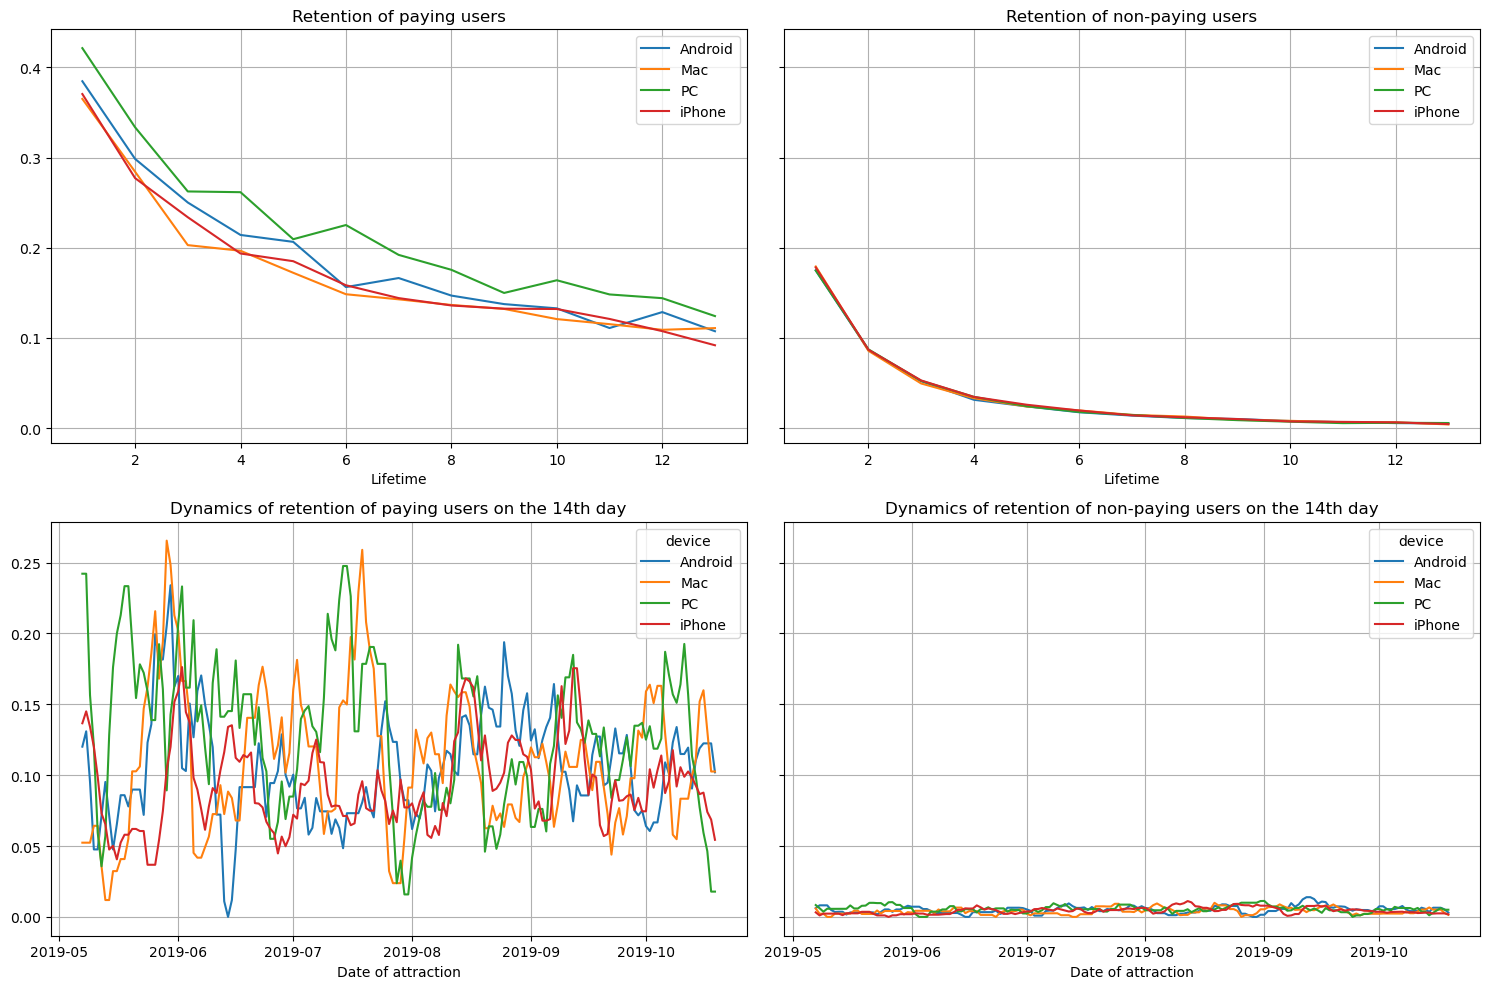

In [45]:
# look at conversion and retention by device:

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)


retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)


plot_conversion(conversion_grouped, conversion_history, horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days) 

Everything is within normal limits

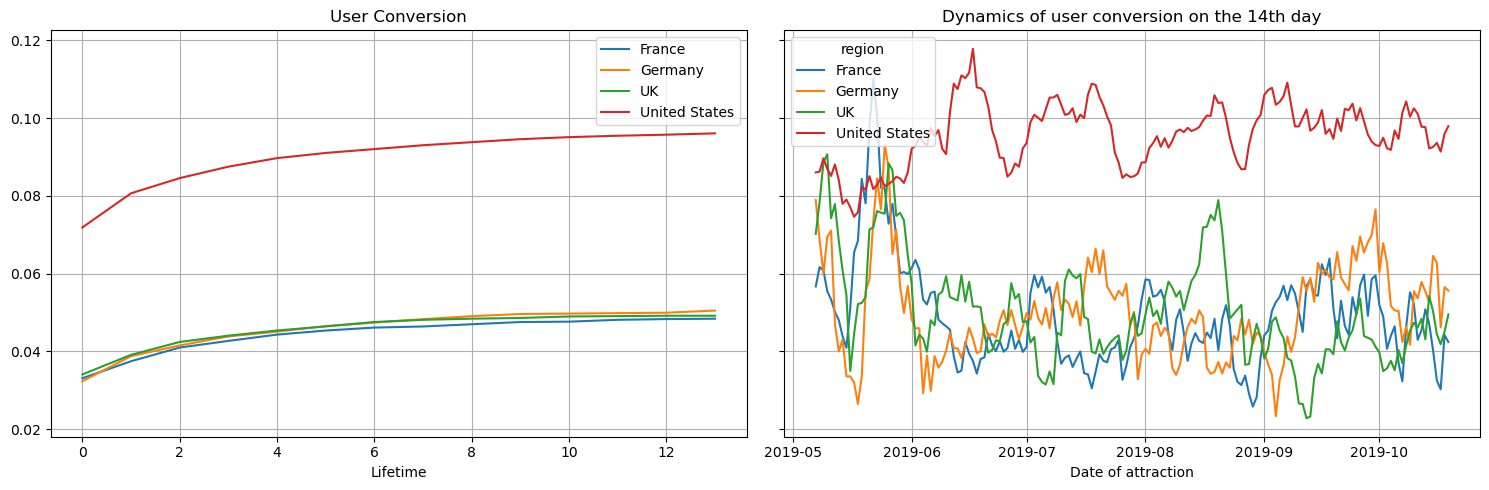

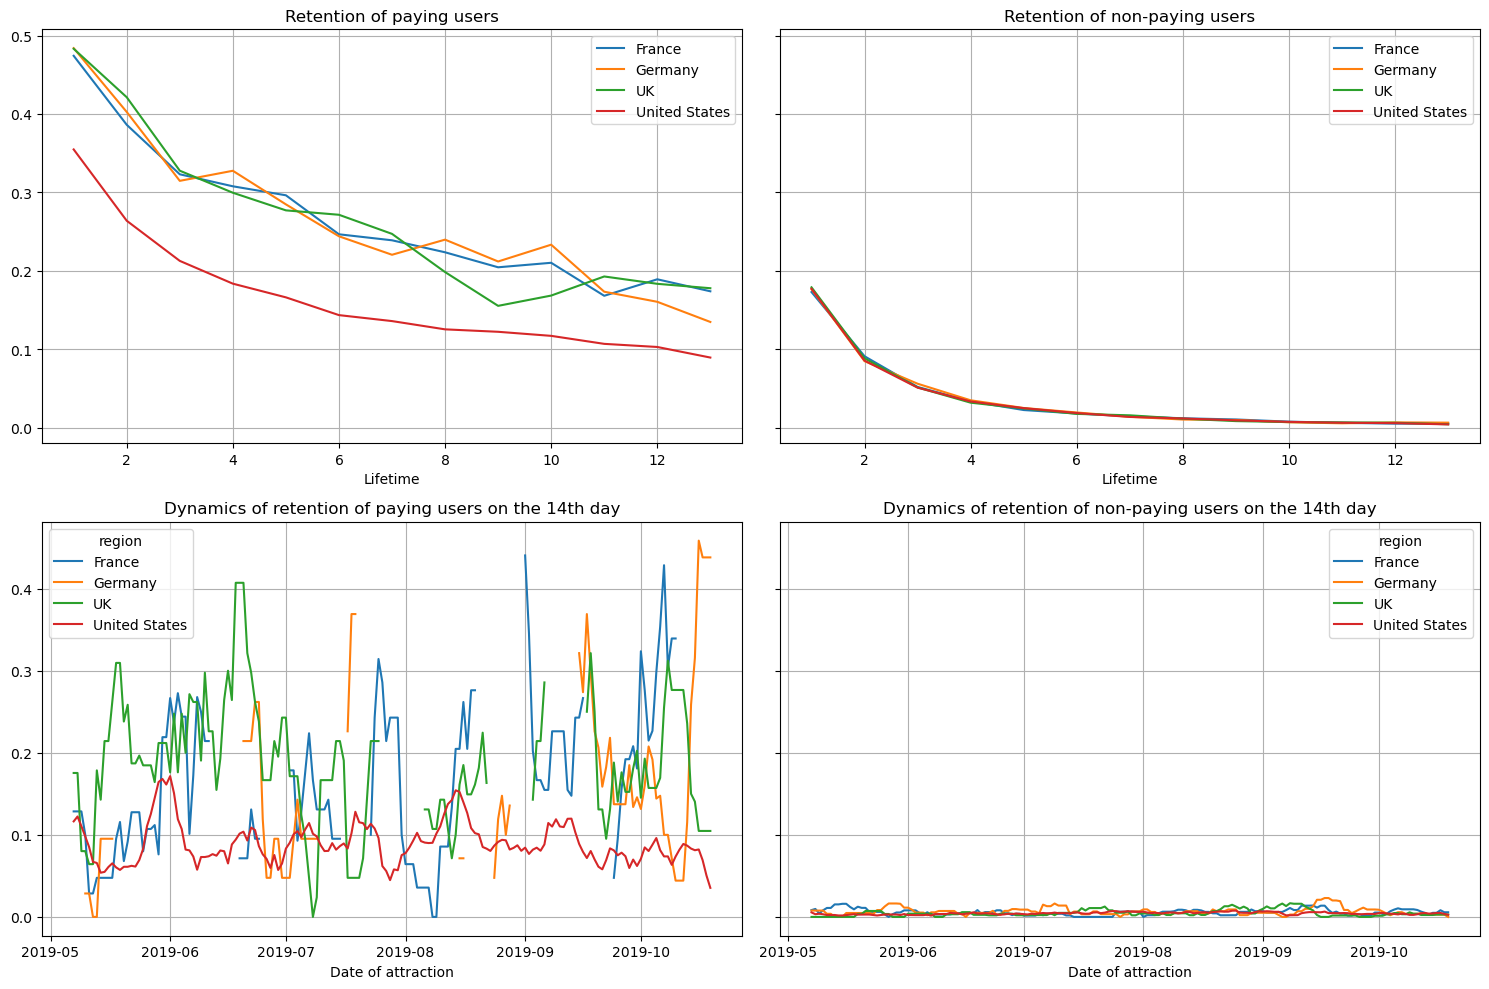

In [46]:
# look at conversion and retention by country:

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)


retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)


plot_conversion(conversion_grouped, conversion_history, horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days) 

We confirm the fact of difficulties with retaining Mr. Biden.

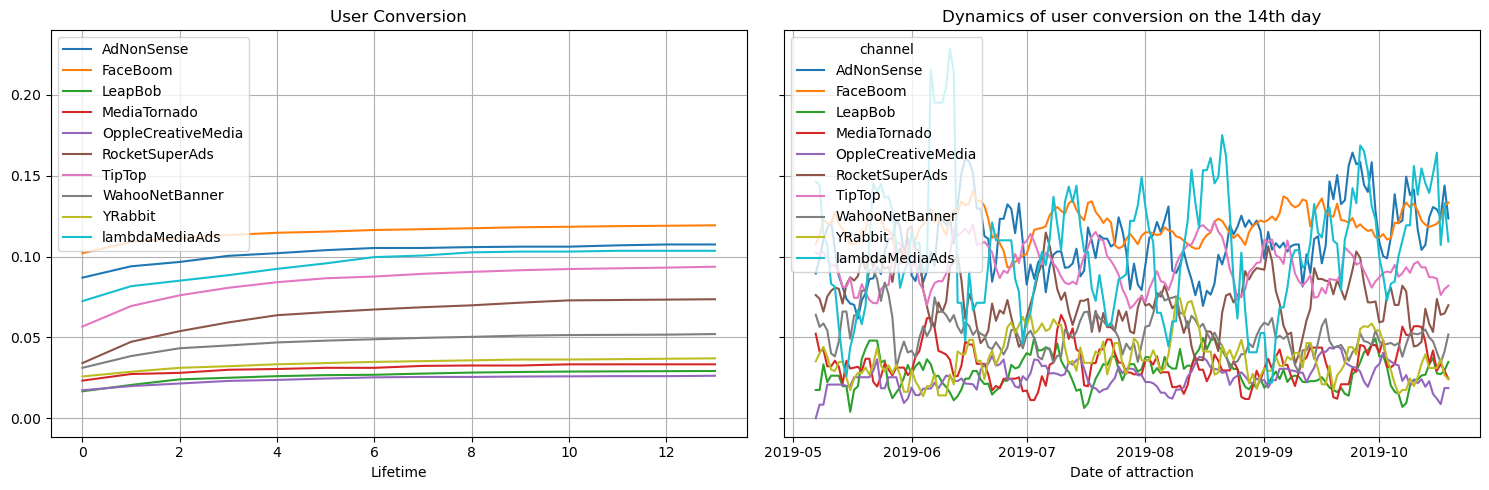

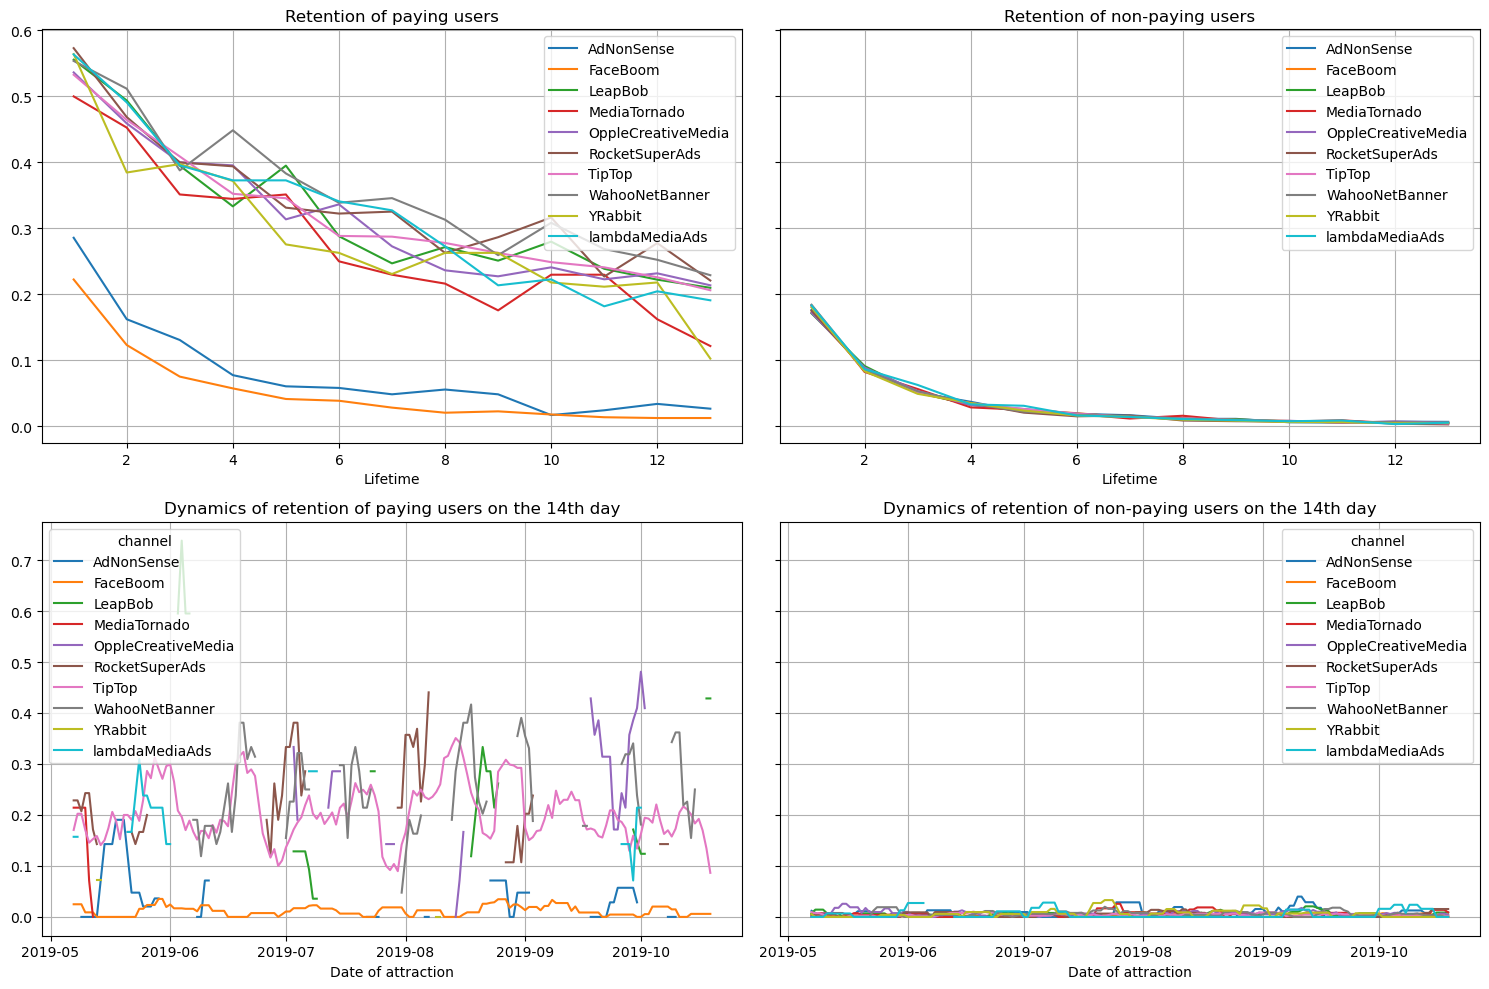

In [47]:
# Let's look at conversion and retention broken down by device:

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)


retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)


plot_conversion(conversion_grouped, conversion_history, horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days) 

Gotcha! Retention of paying users of ANS and FB channels defies decent description. TipTop is justified, but we won’t forget about CAS for it.

## 6. Conclusion.

As part of our research, we were able to identify the reasons for the ineffectiveness of user acquisition. But first things first.

As always, we started with data preprocessing. We checked the datasets for gaps, tidied up the column names, and changed data types as necessary.

We added all the necessary functions and looked at who lives where, as well as what devices those who came use and what advertising channels they respect.

Disappointing conclusions: Advertising companies do not pay off and, to the delight of Russian propagandists, the problem, this time, is true in the United States. Namely:

The vast majority of our Pro procrastinators live in the USA.
The largest number of them use iPhone.
The largest number of paying audiences come through American advertising channels.
Thus, the USA is our main market where everything should be perfect, but two channels let us down and blurred the whole picture. And it would seem that advertising on FaceBoom and TipTop brings us the largest number of paying audiences, but the costs of this advertising are incredibly high.

We have clearly shown that costs are growing weekly and this does not in any way affect the solvency of new adherents of procrastination. At the same time, the results for other channels in the US are excellent! What are the reasons and how to live further?

There is a suspicion that the algorithms for displaying advertisements on FaceBoom, ADS and TipTop are broken. Probably the advertising budget is going down the drain. It is necessary to check the settings of advertising campaigns for these channels. Check targeting, target audience, display time... It is urgent to suspend work on these channels until comprehensive optimization is carried out and errors are identified. And run like Forest. Time is money. A long period of idle advertising will lead to a “cooling down” of the audience and will require new time to build up. Advertising does not work fully from the first day. “Observation” is needed. Most users click on an ad after seeing it several times.

Bottom line: Don't panic!